In [1]:
from dask.distributed import Client
import multiprocessing
ncpu = multiprocessing.cpu_count()
threads = 6
nworker = ncpu//threads
print(f'Number of CPUs: {ncpu}, number of threads: {threads}, number of workers: {nworker}')

Number of CPUs: 48, number of threads: 6, number of workers: 8


In [ ]:
client = Client(processes=True, threads_per_worker=threads, n_workers=nworker, memory_limit='256GB')
client

# Intake to load CMIP data

### Using intake-esm on mistral

- install intake-esm: https://intake-esm.readthedocs.io/en/latest/installation.html
- check the already built catalogs: `/home/mpim/m300524/intake-esm-datastore/catalogs` or `https://github.com/NCAR/intake-esm-datastore/` and skip long catalog building process of running `/home/mpim/m300524/intake-esm-datastore/builders/*.ipynb`

Available catalogs:
- CMIP6
- CMIP5
- MiKlip (homogenization of names across MiKlip generations needed)
- MPI Grand Ensemble

In [16]:
import intake
import xarray as xr
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import pprint
warnings.simplefilter("ignore")
%matplotlib inline
xr.set_options(keep_attrs=True)
import intake_esm
import pymistral
from pymistral.setup import yearmean
import cartopy.crs as ccrs
import cartopy as cp
from climpred.stats import dpp, varweighted_mean_period

In [4]:
intake_esm.__version__

'2019.10.15.post33'

# CMIP6

In [88]:
col_url = "/home/mpim/m300524/intake-esm-datastore/catalogs/mistral-cmip6.json"
col = intake.open_esm_datastore(col_url)

In [89]:
# example: time mean of oceanic CO2 flux in esm-piControl
variable='fgco2'
query = dict(experiment_id=['esm-piControl'], table_id='Omon', 
             variable_id=variable, grid_label=['gn', 'gr'])
cat = col.search(**query)

print(cat.df['source_id'].unique())

['GFDL-ESM4' 'CanESM5' 'CESM2' 'CNRM-ESM2-1']


Credits to Julius Busecke for creating `cmip6_preprocessing`: https://github.com/jbusecke/cmip6_preprocessing

In [90]:
from cmip6_preprocessing.preprocessing import combined_preprocessing
#combined_preprocessing??

In [91]:
dset_dict = cat.to_dataset_dict(cdf_kwargs={'chunks': {'time': 12*50}},
                                preprocess=combined_preprocessing)

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 5 group(s)


In [92]:
# manually check for double entries and delete
del dset_dict['CMIP.NCAR.CESM2.esm-piControl.Omon.gn']

Processing CMIP.CCCma.CanESM5.esm-piControl.Omon.gn
Processing CMIP.CNRM-CERFACS.CNRM-ESM2-1.esm-piControl.Omon.gn
Processing CMIP.NCAR.CESM2.esm-piControl.Omon.gr
Processing CMIP.NOAA-GFDL.GFDL-ESM4.esm-piControl.Omon.gr


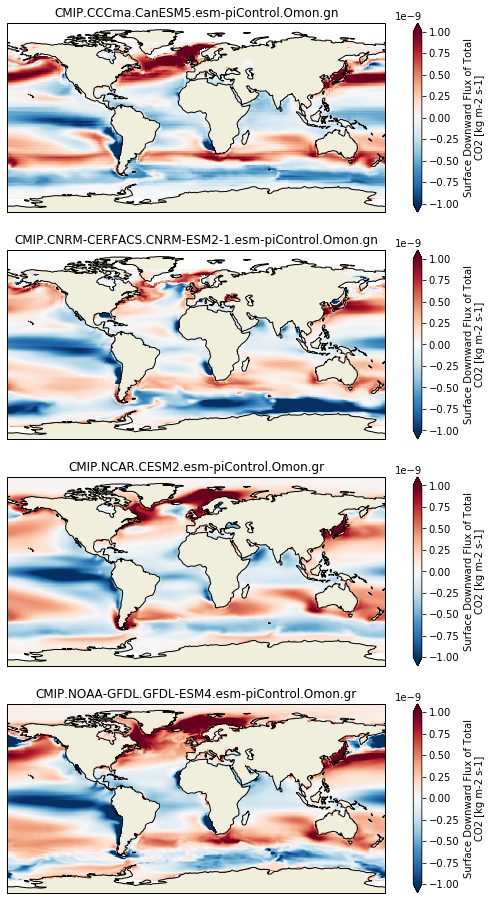

In [94]:
fig, axarr = plt.subplots(nrows=len(dset_dict), figsize=[10,4*len(dset_dict)],
                         subplot_kw={'projection':ccrs.PlateCarree()}
                         )
for ax,(k, ds) in zip(axarr.flat,dset_dict.items()):
    print(f'Processing {k}')
    # do your science here
    ds = ds.mean('time')
    assert len(ds[variable].squeeze().dims) == 2
    ds[variable].squeeze().plot(ax=ax,robust=True,transform=ccrs.PlateCarree(),
                                vmin=-1e-9,vmax=1e-9,cmap='RdBu_r')
    # visuals
    ax.set_title(k)
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cp.feature.LAND)

# CMIP5

In [5]:
col_url = "/home/mpim/m300524/intake-esm-datastore/catalogs/mistral-cmip5.json"
col = intake.open_esm_datastore(col_url)
col.df.head()

,product_id,institute,model,experiment,frequency,modeling_realm,mip_table,ensemble_member,variable,temporal_subset,version,path
0,output1,MOHC,HadGEM2-CC,historical,day,atmos,day,r2i1p1,rhs,19991201-20041130,v20111129,/work/kd0956/CMIP5/data/cmip5/output1/MOHC/Had...
1,output1,MOHC,HadGEM2-CC,historical,day,atmos,day,r2i1p1,rhs,20041201-20051130,v20111129,/work/kd0956/CMIP5/data/cmip5/output1/MOHC/Had...
2,output1,MOHC,HadGEM2-CC,historical,day,atmos,day,r2i1p1,rhs,19791201-19841130,v20111129,/work/kd0956/CMIP5/data/cmip5/output1/MOHC/Had...
3,output1,MOHC,HadGEM2-CC,historical,day,atmos,day,r2i1p1,rhs,19591201-19641130,v20111129,/work/kd0956/CMIP5/data/cmip5/output1/MOHC/Had...
4,output1,MOHC,HadGEM2-CC,historical,day,atmos,day,r2i1p1,rhs,19841201-19891130,v20111129,/work/kd0956/CMIP5/data/cmip5/output1/MOHC/Had...


In [7]:
uni_dict = col.unique(['model', 'institute', 'mip_table','experiment'])
pprint.pprint(uni_dict, compact=True)

{'experiment': {'count': 101,
                'values': ['historical', 'piControl', 'rcp85', 'midHolocene',
                           'rcp45', 'amip4K', 'aqua4xCO2', 'sstClim',
                           'sstClimAerosol', 'sstClimSulfate', 'amip4xCO2',
                           'amip', 'sstClim4xCO2', 'aqua4K', 'aquaControl',
                           'amipFuture', 'decadal2001', 'decadal1982',
                           'decadal1961', 'decadal2003', 'decadal1973',
                           'decadal1963', 'decadal1975', 'decadal1996',
                           'decadal2005', 'decadal2000', 'decadal1988',
                           'decadal2002', 'decadal1972', 'decadal1977',
                           'decadal2008', 'decadal1986', 'decadal1968',
                           'decadal1999', 'decadal1967', 'decadal1992',
                           'decadal1990', 'decadal1978', 'decadal1960',
                           'decadal1984', 'decadal1976', 'decadal1980',
                       

In [8]:
dset_dict = col.search(experiment='esmControl',variable='fgco2').to_dataset_dict(cdf_kwargs={'chunks': {'time': 12*50}})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'institute.model.experiment.mip_table'

--> There will be 14 group(s)


In [31]:
# example: take a single dataset out of dict
ds = dset_dict['MPI-M.MPI-ESM-LR.esmControl.Omon']['fgco2'].squeeze().load()

# MiKlip
MiKlip data is cmorized based on `CMIP5` conventions.
The following catalog `col` contains output from 5 `generation`s of MiKlip output from `/work/bmx828/miklip-ces/data4miklip/model/global/miklip/`.

- Marotzke, Jochem, Wolfgang A. Müller, Freja S. E. Vamborg, Paul Becker, Ulrich Cubasch, Hendrik Feldmann, Frank Kaspar, et al. “MiKlip: A National Research Project on Decadal Climate Prediction.” Bulletin of the American Meteorological Society 97, no. 12 (June 17, 2016): 2379–94. https://doi.org/10/gddfck.


In [12]:
col_url = "/home/mpim/m300524/intake-esm-datastore/catalogs/mistral-miklip.json"
col = intake.open_esm_datastore(col_url)
col.df.head()

,generation,product_id,institute,model,experiment,frequency,modeling_realm,mip_table,ensemble_member,variable,temporal_subset,version,path
0,baseline0,output1,MPI-M,MPI-ESM-LR,decadal2001,day,atmos,day,r2i1p1,sfcWind,20020101-20111231,v20111122,/work/bmx828/miklip-ces/data4miklip/model/glob...
1,baseline0,output1,MPI-M,MPI-ESM-LR,decadal2001,day,atmos,day,r2i1p1,tas,20020101-20111231,v20111122,/work/bmx828/miklip-ces/data4miklip/model/glob...
2,baseline0,output1,MPI-M,MPI-ESM-LR,decadal2001,day,atmos,day,r2i1p1,psl,20020101-20111231,v20111122,/work/bmx828/miklip-ces/data4miklip/model/glob...
3,baseline0,output1,MPI-M,MPI-ESM-LR,decadal2001,day,atmos,day,r2i1p1,pr,20020101-20111231,v20111122,/work/bmx828/miklip-ces/data4miklip/model/glob...
4,baseline0,output1,MPI-M,MPI-ESM-LR,decadal2001,day,atmos,day,r2i1p1,tasmin,20020101-20111231,v20111122,/work/bmx828/miklip-ces/data4miklip/model/glob...


In [13]:
col.df.nunique()

generation               6
product_id               4
institute                4
model                    5
experiment             402
frequency                8
modeling_realm           7
mip_table               21
ensemble_member         93
variable               276
temporal_subset       2727
version                 22
path               1773282
dtype: int64

In [ ]:
import pprint
uni_dict = col.unique(['generation', 'product_id'])
pprint.pprint(uni_dict, compact=True)

In [37]:
# example: comparing inits from 1991 from two generations
cat = col.search(model='MPI-ESM-LR',variable='tas',frequency='mon',
                 ensemble_member=['r1i1p1','r2i1p1','r3i1p1'],
                 experiment=['decs4e1991','decs4e1992','decadal1991','decadal1992'])

In [38]:
dset_dict = cat.to_dataset_dict(cdf_kwargs={'chunks': {'time': 12*5}})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'institute.model.experiment.mip_table'

--> There will be 4 group(s)


In [44]:
ds = xr.concat([i['tas'].squeeze().mean('ensemble_member') for i in dset_dict.values()],'run')
ds['run']=list(dset_dict.keys())

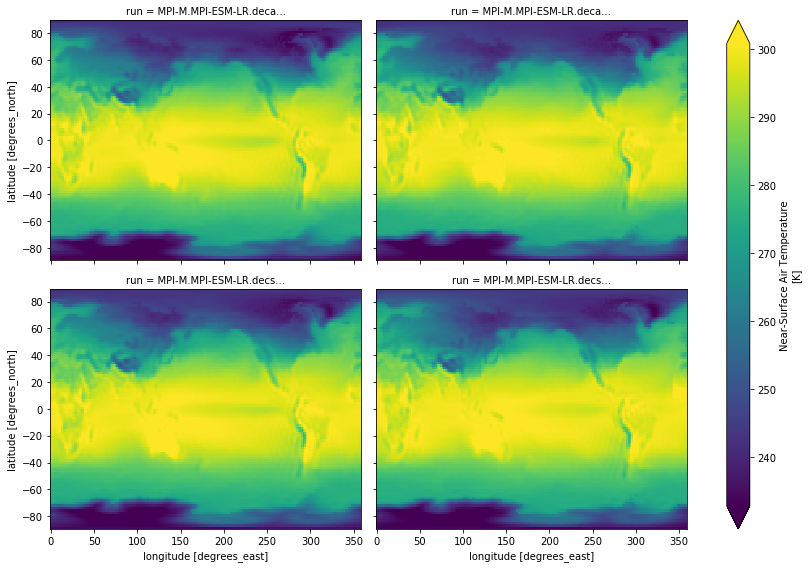

In [54]:
# plot one target timestep: Feb 93
ds.sel(time='1993-02').squeeze().plot(col='run',col_wrap=2,robust=True,figsize=(12,8))

# MPI Grand Ensemble

Max Planck Institute Grand Ensemble (Maher et al. 2019 https://doi.org/10/gf3kgt) cmorized by CMIP5-standards accessible on the DKRZ's MISTRAL disk storage system in /work/mh1007/CMOR/MPI-GE.

In [22]:
col_url = "/home/mpim/m300524/intake-esm-datastore/catalogs/mistral-MPI-GE.json"
col = intake.open_esm_datastore(col_url)
col.df.head()

,product_id,institute,model,experiment,frequency,modeling_realm,mip_table,ensemble_member,variable,temporal_subset,version,path
0,output1,MPI-M,MPI-ESM,piControl,mon,atmos,Amon,1,prsn,310001-319912,v20190123,/work/mh1007/CMOR/MPI-GE/output1/MPI-M/MPI-ESM...
1,output1,MPI-M,MPI-ESM,piControl,mon,atmos,Amon,1,prsn,380001-385012,v20190123,/work/mh1007/CMOR/MPI-GE/output1/MPI-M/MPI-ESM...
2,output1,MPI-M,MPI-ESM,piControl,mon,atmos,Amon,1,prsn,230001-239912,v20190123,/work/mh1007/CMOR/MPI-GE/output1/MPI-M/MPI-ESM...
3,output1,MPI-M,MPI-ESM,piControl,mon,atmos,Amon,1,prsn,280001-289912,v20190123,/work/mh1007/CMOR/MPI-GE/output1/MPI-M/MPI-ESM...
4,output1,MPI-M,MPI-ESM,piControl,mon,atmos,Amon,1,prsn,190001-199912,v20190123,/work/mh1007/CMOR/MPI-GE/output1/MPI-M/MPI-ESM...


In [46]:
# example: GMST for three members in historical with all scenarios
cat = col.search(variable='tas',mip_table='Amon',
                 ensemble_member=[1,50,100],
                 experiment=['historical','rcp26','rcp45','rcp85'])

In [47]:
dset_dict = cat.to_dataset_dict(cdf_kwargs={'chunks': {'time': 12*20}})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'institute.model.experiment.mip_table'

--> There will be 4 group(s)


In [52]:
dset_dict.keys()

dict_keys(['MPI-M.MPI-ESM.historical.Amon', 'MPI-M.MPI-ESM.rcp26.Amon', 'MPI-M.MPI-ESM.rcp45.Amon', 'MPI-M.MPI-ESM.rcp85.Amon'])

In [68]:
ds = xr.merge([list(dset_dict.values())[0],xr.concat(list(dset_dict.values())[1:],'experiment')])

In [80]:
ds['experiment'] = ['RCP2.6','RCP4.5','RCP8.5']

In [81]:
gmst = ds.mean(['lon','lat'])['tas']

In [82]:
gmst = gmst.groupby('time.year').mean('time')
del gmst['height']

Text(0.5, 1.0, 'MPI Grand Ensemble: GMST')

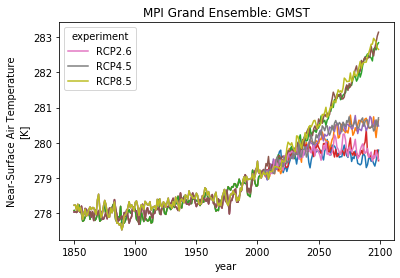

In [85]:
for member in gmst.ensemble_member:
    gmst.sel(ensemble_member=member).plot.line(hue='experiment')
plt.title('MPI Grand Ensemble: GMST')